**Prediccion precio acciones usando Long short-term Memory**

Luis Carlos Figueroa Benitez

Cristian Alexis Diaz Rodriguez

In [1]:
!pip install yfinance
!pip install cryptocmd

In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from cryptocmd import CmcScraper
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [3]:
ticker = 'TSLA'
datePredstart = '07-08-2015'  # '01-01-2014' '31-03-2022' 
datePredend = '31-03-2022'

scraper = CmcScraper(ticker, datePredstart, datePredend ,order_ascending= True) 
data = scraper.get_dataframe()

print(data)
print(data.shape[0])

          Date         Open         High          Low        Close  \
0   2020-12-08   648.150000   665.300000   620.400000   648.900000   
1   2020-12-09   650.000000   654.600000   589.650000   593.650000   
2   2020-12-10   593.650000   622.550000   571.300000   620.400000   
3   2020-12-11   620.400000   623.150000   594.650000   608.100000   
4   2020-12-12   608.100000   612.200000   606.150000   606.200000   
..         ...          ...          ...          ...          ...   
474 2022-03-27  1082.581696  1108.459045  1032.575269  1099.340288   
475 2022-03-28  1099.363103  1139.028080  1027.946177  1121.588402   
476 2022-03-29  1121.641148  1164.047319  1099.260355  1133.739346   
477 2022-03-30  1133.729056  1173.041257  1114.508656  1137.515993   
478 2022-03-31  1137.549931  1241.028307  1116.075159  1181.494648   

           Volume  Market Cap  
0    3.993673e+04           0  
1    5.674946e+04           0  
2    5.263033e+04           0  
3    8.078915e+04           0  

In [4]:
train_length = round(data.shape[0]/2)
train_length

240

In [5]:
train_length = round(data.shape[0]/2)
df = data 
training_set = df.iloc[:train_length, 4:5].values
test_set = df.iloc[train_length:, 4:5].values
test_set
print(df.shape[0]-train_length)

239


In [6]:
# Feature Scaling

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, train_length):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
6/6 [==============================] - 13s 198ms/step - loss: 0.0937
Epoch 2/100
6/6 [==============================] - 1s 220ms/step - loss: 0.0328
Epoch 3/100
6/6 [==============================] - 1s 201ms/step - loss: 0.0268
Epoch 4/100
6/6 [==============================] - 1s 202ms/step - loss: 0.0235
Epoch 5/100
6/6 [==============================] - 1s 207ms/step - loss: 0.0236
Epoch 6/100
6/6 [==============================] - 1s 213ms/step - loss: 0.0203
Epoch 7/100
6/6 [==============================] - 1s 179ms/step - loss: 0.0198
Epoch 8/100
6/6 [==============================] - 1s 190ms/step - loss: 0.0208
Epoch 9/100
6/6 [==============================] - 1s 197ms/step - loss: 0.0186
Epoch 10/100
6/6 [==============================] - 1s 182ms/step - loss: 0.0204
Epoch 11/100
6/6 [==============================] - 1s 195ms/step - loss: 0.0174
Epoch 12/100
6/6 [==============================] - 1s 214ms/step - loss: 0.0222
Epoch 13/100
6/6 [==================

In [8]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:train_length, 4:5]
dataset_test = df.iloc[train_length:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, df.shape[0]-train_length+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(239, 60, 1)


In [9]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


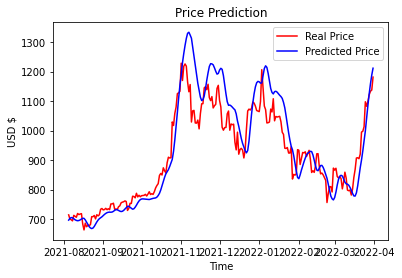

Error de predicción R2 es:  0.7632435376098547
Error de predicción MAE es:  53.341248400819076


In [10]:
# Visualising the results
plt.plot(df.loc[train_length:, 'Date'],dataset_test.values[:], color = 'red', label = 'Real Price')
plt.plot(df.loc[train_length:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted Price')
#plt.xticks(np.arange(0,459,50))

plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('USD $')
plt.legend()
plt.show()

mae = mean_absolute_error(dataset_test.values,predicted_stock_price)
r2 = r2_score(dataset_test.values,predicted_stock_price)
print("Error de predicción R2 es: ",r2)
print("Error de predicción MAE es: ",mae)

